#### Dependencies

In [1]:
# !pip install numpy num2words nltk pandas Observations gensim
# import nltk
# nltk.download('stopwords')
# nltk.download('punkt')
# nltk.download('wordnet')
# !pip install -U textblob
# !python -m textblob.download_corpora

#### Imports

In [25]:
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import PorterStemmer
from num2words import num2words
from collections import Counter
from scipy import spatial
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.decomposition import LatentDirichletAllocation
from scipy.special import gammaln
from collections import Counter
from textblob import TextBlob
from sklearn.manifold import TSNE
from pylab import savefig
from sklearn.ensemble import IsolationForest
from sklearn.cluster import DBSCAN
from scipy.stats import chi2

import plotly
import plotly.plotly as py
import plotly.graph_objs as go
import imp
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import gensim
import pickle
import lda2
import scipy
import operator
import nltk
import os
import string
import copy
import pickle

In [26]:
imp.reload(lda2)

<module 'lda2' from 'lda2.pyc'>

In [38]:
import gzip

In [48]:
def parse(path):
  g = gzip.open(path, 'r')
  for l in g:
    yield eval(l)

In [49]:
data = parse("reviews_Musical_Instruments_5.json.gz")

In [51]:
data = pd.DataFrame(list(data))

In [56]:
reviews = data['reviewText'].values

In [59]:
ratings = data['overall'].values

### Preprocessing Methods

In [4]:
def convert_numbers(k):
    for i in range(len(k)):
        try:
            num2words(int(k[i]))
            k[i] = " "
        except:
            pass
    return k

def get_cosine(a, b):
    return 1 - spatial.distance.cosine(a, b)

def preprocess(pd):
    pd = pd.str.lower()
    pd = pd.str.replace('[{}]'.format('!"#$%&\'()*+,-./:;<=>?@[\\]^_`{|}~\n\t'), ' ')
    pd = pd.apply(lambda x: [w for w in w_tokenizer.tokenize(x)])
    pd = pd.apply(lambda x: convert_numbers(x))
    pd = pd.str.join(' ')
    
    pd = pd.apply(lambda x: [lemmatizer.lemmatize(w) for w in w_tokenizer.tokenize(x)])    
    pd = pd.apply(lambda x: [item for item in x if item not in stop_words])
    return pd

def processReviews(reviews, window=5, MAX_VOCAB_SIZE=1000):
    vectorizer = CountVectorizer(analyzer="word",tokenizer=None)
    count_matrix = vectorizer.fit_transform(reviews)
    tfidf_vectorizer = TfidfVectorizer()
    tfidf_matrix = tfidf_vectorizer.fit_transform(reviews)
    words = vectorizer.get_feature_names()
    vocabulary = dict(zip(words,np.arange(len(words))))
    inv_vocabulary = dict(zip(np.arange(len(words)),words))
    return count_matrix.toarray(), tfidf_matrix.toarray(), vocabulary, words

### Score Methods

In [5]:
def coherence_score(X, topic_sentiment_df):
    X[X>1] = 1    
    totalcnt = len(topic_sentiment_df)
    total = 0
    for allwords in topic_sentiment_df:
        for word1 in allwords:
            for word2 in allwords:
                if word1 != word2:
                    ind1 = vocabulary[word1]
                    ind2 = vocabulary[word2]
                    total += np.log((np.matmul(X[:,ind1].T, X[:,ind2]) + 1.0)/np.sum(X[:,ind2]))
    return total/(2*totalcnt)

def kl_score(pk,qk):
    return (scipy.stats.entropy(pk,qk)*.5 + scipy.stats.entropy(qk,pk)*.5)

def get_hscore(dt_distribution, X, k):
    testlen = X.shape[0]
    all_kl_scores = np.zeros((testlen, testlen))
    for i in range(testlen-1):
        for j in range(i+1,testlen):
            score = kl_score(dt_distribution[i],dt_distribution[j])
            all_kl_scores[i,j] = score
            all_kl_scores[j,i] = score

    dt = np.zeros((X.shape[0], k))

    for i in range(X.shape[0]):
        dt[i, dt_distribution[i].argmax()]=1

    intradist = 0
    for i in range(k):
        cnt = dt[:,i].sum()
        tmp = np.outer(dt[:,i],dt[:,i])
        tmp = tmp * all_kl_scores
        intradist += tmp.sum()*1.0/(cnt*(cnt-1))
    intradist = intradist/k
    

    interdist = 0
    for i in range(k):
       for j in range(k):
           if i != j:
             cnt_i = dt[:,i].sum()
             cnt_j = dt[:,j].sum()
             tmp = np.outer(dt[:,i], dt[:,j])
             tmp = tmp * all_kl_scores
             interdist += tmp.sum()*1.0/(cnt_i*cnt_j)
    interdist = interdist/(k*(k-1))
    return intradist/interdist

### Required Methods

In [6]:
def plot_simple_TSNE(data, title):
    X_embedded = TSNE(n_components=2).fit_transform(data)

    X = np.array([i[0] for i in X_embedded])
    Y = np.array([i[1] for i in X_embedded])
    plt.scatter(X, Y)

    plt.title(title)
    plt.legend(loc=(1.04,0))
    plt.show()

def plot_TSNE(dt_distribution, C, labels, printit, title):
    X_embedded = TSNE(n_components=2).fit_transform(dt_distribution)
    plt.figure(figsize=(10, 10))
    X = np.array([i[0] for i in X_embedded])
    Y = np.array([i[1] for i in X_embedded])
    for i in range(len(labels)):
        xx = X[[np.where(C == i)[0].tolist()]]
        yy = Y[[np.where(C == i)[0].tolist()]]
        plt.scatter(xx, yy, label=labels[i])

    if printit:
        for idx, p in enumerate(X_embedded):
            plt.annotate(idx, (p[0], p[1]))
    plt.title(title)
    plt.legend(loc=(1.04,0))
    plt.show()
    
def get_doc_details(num):
    print("label: ", C[num])
    print(dataset[9].values[num])

### Read Data

In [7]:
dataset1 = pd.read_pickle("dataset_cleaned_autocorrected")

In [8]:
dataset1['Case Number'] = dataset1['Case Number'].apply(lambda x: "old: " + str(x).split(" ")[1])

In [9]:
dataset2 = pd.read_pickle("dataset_cleaned_autocorrected2")

In [10]:
dataset2.rename(columns={0: 'Case Number', 1: 'Text'}, inplace=True)

In [11]:
dataset2['Case Number'] = dataset2['Case Number'].apply(lambda x: "new: " + str(x))

In [12]:
dataset = pd.concat([dataset1, dataset2], axis=0)

In [13]:
dataset = dataset.reset_index().drop(['index'], axis=1)

In [14]:
icd_words = pd.read_csv("strict_medical_words.txt", header=None)[0].values.tolist()

In [15]:
embeddings_index = gensim.models.KeyedVectors.load_word2vec_format('pubmed2018_w2v_200D/pubmed2018_w2v_200D.bin', binary=True)

/root/miniconda3/envs/python2/lib/python2.7/site-packages/smart_open/smart_open_lib.py:398: UserWarning:

This function is deprecated, use smart_open.open instead. See the migration notes for details: https://github.com/RaRe-Technologies/smart_open/blob/master/README.rst#migrating-to-the-new-open-function



In [16]:
# embeddings_index.most_similar(positive=[embeddings_index['female']], topn=1000)

### Prepare Data

In [17]:
dataset[8] = dataset[7].apply(lambda x: [item for item in x.split(" ") if item in icd_words])
dataset[9] = dataset[8].apply(lambda x: " ".join(x))

In [18]:
count_matrix, tfidf_matrix, vocabulary, words = processReviews(dataset[9].values)

In [19]:
count_matrix.shape, tfidf_matrix.shape

((252, 572), (252, 572))

### Find Edges

In [20]:
edges_threshold = 0.5

In [21]:
docs_edges, ignored, taken, count = [], [], [], 0
for idx, doc in enumerate(dataset[8].values):
    edges = []
    for i in doc:
        for j in doc:
            if i != j:
                try:
                    a = embeddings_index[i]
                    b = embeddings_index[j]
                    if get_cosine(a, b) > edges_threshold and (vocabulary[i], vocabulary[j]) not in edges and (vocabulary[j], vocabulary[i]) not in edges:
                        edges.append((vocabulary[i], vocabulary[j]))
                except:
                    try:
                        embeddings_index[i]
                        taken.append(i)
                    except:
                        ignored.append(i)
                    try:
                        embeddings_index[j]
                    except:
                        ignored.append(j)
                        taken.append(j)
                    pass
    docs_edges.append(edges)

In [22]:
edge_dict = {}
for i in docs_edges:
    for j in i:
        try:
            edge_dict[j[0]] += [j[1]]
            edge_dict[j[1]] += [j[0]]
        except:
            edge_dict[j[0]] = [j[1]]
            edge_dict[j[1]] = [j[0]]

In [23]:
for i in edge_dict.keys():
    edge_dict[i] = list(set(edge_dict[i]))

In [24]:
len(edge_dict)

294

## Run Model

In [25]:
k = N_TOPICS = 9
lambda_param = 1.0

In [26]:
imp.reload(lda2)

<module 'lda2' from 'lda2.pyc'>

In [27]:
sampler = lda2.LdaSampler(n_topics=N_TOPICS, lambda_param=lambda_param)

In [28]:
for it, phi in enumerate(sampler.run(count_matrix, edge_dict, maxiter=100)):
    sampler.loglikelihood(docs_edges)

In [29]:
t_words = sampler.getTopKWords(5, words)
top_words = [t_words[i] for i in t_words.keys()]
document_topic = sampler.theta().argmax(axis=1)

### Evaluation

In [30]:
coherence_score(count_matrix, top_words)

-10.724783747215197

In [31]:
get_hscore(sampler.theta(), count_matrix, k)

0.16005533222409765

In [32]:
topics_generated = sampler.theta().argmax(axis=1)
document_word_sampler = np.dot(sampler.theta(), sampler.phi())

In [33]:
top_words

[[u'operation', u'old', u'diagnosis', u'admission', u'eye'],
 [u'urine', u'skin', u'sepsis', u'lap', u'neonatal'],
 [u'stone', u'abdomen', u'discharge', u'fever', u'ureter'],
 [u'pulse', u'hip', u'sac', u'schedule', u'respiratory'],
 [u'admission', u'complication', u'proximal', u'distal', u'chest'],
 [u'bilirubin', u'cyanosis', u'inguinal', u'pallor', u'scrotum'],
 [u'angioplasty', u'using', u'artery', u'dominant', u'proximal'],
 [u'female', u'department', u'diagnosis', u'admission', u'treatment'],
 [u'chemotherapy', u'cancer', u'carcinoma', u'cycle', u'surgical']]

### Visualizing D-T

In [34]:
labels = list(xrange(N_TOPICS))
labels = ['Treatment', 'Heart Surgery', 'Symptoms', 'Procedure', 'Pregnency', 'Clinical', 'Tests', 'Cancer', 'Abdomen']
print(labels)

['Treatment', 'Heart Surgery', 'Symptoms', 'Procedure', 'Pregnency', 'Clinical', 'Tests', 'Cancer', 'Abdomen']


/root/miniconda3/envs/python2/lib/python2.7/site-packages/ipykernel_launcher.py:18: FutureWarning:

Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.

/root/miniconda3/envs/python2/lib/python2.7/site-packages/ipykernel_launcher.py:19: FutureWarning:

Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.



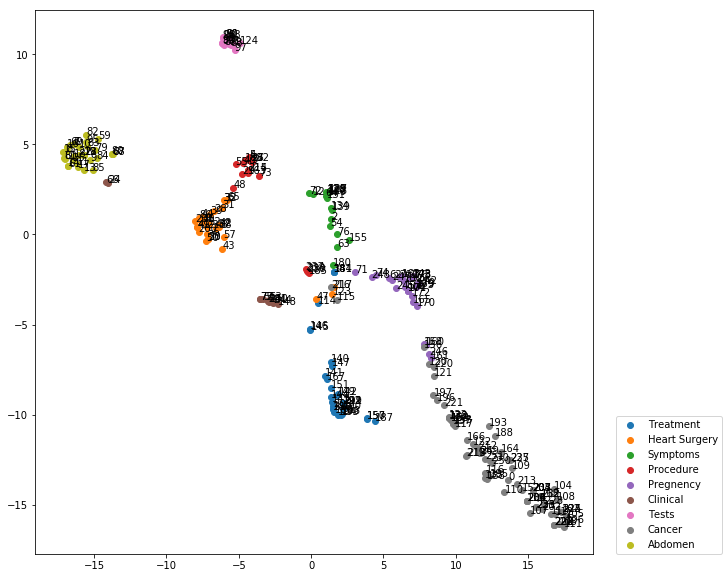

In [35]:
plot_TSNE(document_word_sampler, topics_generated, labels, True, "")

### Required Funcitons

In [36]:
def sample_data(data, topics, topic_selected):
    sampled, idxx = [], []
    for idx, i in enumerate(topics):
        if i == topic_selected:
            sampled.append(data[idx].tolist())
            idxx.append(dataset['Case Number'][idx])
    return np.array(sampled), idxx

In [37]:
def get_mahalanobis(matrix):
    return (np.dot(np.dot(np.array(matrix - np.mean(matrix, axis=0)), 
                         np.linalg.inv(np.cov(matrix.T))), np.array(matrix - np.mean(matrix, axis=0)).T)).diagonal()

In [38]:
def print_doc(ider):
    print(dataset[dataset['Case Number']==ider][9].values[0])

# getting outlyers

In [39]:
reduced_dim = TSNE(n_components=2).fit_transform(document_word_sampler)

In [40]:
sampled_all, idxx_all, mahalanobis_all = [], [], []
for topic in range(N_TOPICS):
    sampled, idxx = sample_data(reduced_dim, topics_generated, topic)
    sampled_all.append(sampled)
    idxx_all.append(idxx)
    mahalanobis_all.append(get_mahalanobis(sampled))

# Threshold

In [41]:
t = chi2.ppf(0.90, 2)

In [59]:
a_docs = []
for l, (m, idxxs) in enumerate(zip(mahalanobis_all, idxx_all)):
    print(l, [idxxs[i] for i in np.where(m>t)[0].tolist()])
    a_docs += [idxxs[i] for i in np.where(m>t)[0].tolist()]

(0, ['old: 35', 'new: 51', 'new: 58', 'new: 102', 'new: 105', 'new: 108'])
(1, ['old: 36', 'old: 48', 'old: 66', 'new: 24', 'new: 138'])
(2, ['new: 56', 'new: 81'])
(3, ['old: 49'])
(4, ['old: 72', 'new: 62', 'new: 167', 'new: 169'])
(5, [])
(6, ['new: 25'])
(7, ['new: 16', 'new: 21', 'new: 22', 'new: 57', 'new: 109', 'new: 114', 'new: 137', 'new: 141'])
(8, ['old: 68', 'old: 69'])


In [60]:
print(idxx_all[0])

['old: 35', 'new: 15', 'new: 41', 'new: 42', 'new: 43', 'new: 44', 'new: 45', 'new: 46', 'new: 47', 'new: 48', 'new: 50', 'new: 51', 'new: 52', 'new: 58', 'new: 68', 'new: 102', 'new: 105', 'new: 107', 'new: 108', 'new: 110', 'new: 111', 'new: 112', 'new: 113', 'new: 115', 'new: 119', 'new: 120', 'new: 129', 'new: 130', 'new: 131', 'new: 132']


In [61]:
# new: 121 - heart, sleep, jaundice
# new: 27, 28, 30, 31, 32, 40, 56 - heart and bladder together
# old: 36 - oral breast
# old: 66 - eye fever oral

In [62]:
for i in (a_docs):
    print("\n"+i)
    print_doc(i)


old: 35


new: 51
discharge old urology laparoscopic admission diagnosis treatment pathology urine urea facility

new: 58
discharge department infertility carpal admission discharge diagnosis uterine course antibiotic antacid fluid treatment abdomen uterus intramural uterine laparoscopic hysterectomy specimen laparoscopic hysterectomy discharge pulse urine treatment

new: 102


new: 105


new: 108
discharge female discharge discharge medicine discharge eye eye

old: 36
perinatal asphyxia respiratory neonatal staphylococcus aureus sepsis oral breast immunization schedule screening

old: 48
lap urine granular infestation dune

old: 66
febrile convulsion multiple fever generalized tonic clonic convulsion limb eye toxic dehydration skin decreased pallor eye febrile cell transfusion oral

new: 24
wet discharge transfusion admission discharge diagnosis delayed specie breathing birth delayed birth

new: 138
college discharge unit admission treatment toxic long extent

new: 56
department disc

In [45]:
print_doc("new: 56")

department discharge diagnosis bladder renal abdomen micturition course antibiotic antiemetic analgesia fluid treatment abdomen renal bladder complication discharge heart fluid treatment


In [46]:
py.sign_in("william18026", "wC9Ph9QUtlZr4las0C2p")

In [ ]:
# labels = ['Tests', 'Anesthesia', 'Oral', 'Cancer', "Fracture", 'HIV', 'Kidney Stone', 'Allergy', 'Heart']

In [ ]:
traces = []
for i in range(N_TOPICS):
    X = []
    Y = []
    idds = []
    for idx, j in enumerate(topics_generated):
        if j == i:
            X.append(reduced_dim[idx][0])
            Y.append(reduced_dim[idx][1])
            idds.append(dataset['Case Number'][idx])
    trace = go.Scatter(
        x = X,
        y = Y,
        text = idds,
        mode = 'markers',
        name = labels[i],
        marker = dict(
            line = dict(width = 1)
        )
    )
    traces.append(trace)

In [ ]:
py.iplot(traces, filename='basic-scatter-2')

In [69]:
dataset.head(67)

,Case Number,Text,6,7,8,9
0,old: 1,NKH MULTI SPECIALITY HOSPITAL AND TRAUMA CENTE...,"[nkh, multi, speciality, hospital, trauma, cen...",nkh multi speciality trauma center chhattisgar...,"[multi, trauma, cerebrovascular, accident, fib...",multi trauma cerebrovascular accident fibula h...
1,old: 2,"CHC NELASHNAR Hospital, Chhattisgarh Case No. ...","[chc, nelashnar, hospital, chhattisgarh, case,...",chc nelashnar chhattisgarh hs22018012 p9078 ma...,"[malaria, oral]",malaria oral
2,old: 3,"PHC BHANBEDA HOSPITAL, Chhattisgarh\nCase No. ...","[phc, bhanbeda, hospital, chhattisgarh, case, ...",phc bhanbeda chhattisgarh hs22014050 s965 inte...,"[fever, therapy, typhoid, fever, fever]",fever therapy typhoid fever fever
3,old: 4,"111 SAVE LIFE HOSPITAL, JHARKHAND\nCase No. CA...","[save, life, hospital, jharkhand, case, case, ...",save life hosp20p195371p127634 version hydroce...,"[hydrocele, sac, unilateral, schedule, anesthe...",hydrocele sac unilateral schedule anesthetic g...
4,old: 5,111 SAVE LIFE HOSPITAL\nCase No. CASE/HOSP20 P...,"[save, life, hospital, case, case, hosp20, p19...",save life p19537 p128685 version hydrocele sac...,"[hydrocele, sac, unilateral, schedule, scrotal...",hydrocele sac unilateral schedule scrotal anes...
5,old: 6,111 SAVE LIFE HOSPITAL\nCase No. CASE/HOSP20P1...,"[save, life, hospital, case, case, hosp20p1953...",save life hosp20p19537 p156478 version hydroce...,"[hydrocele, sac, unilateral, schedule, scrotal...",hydrocele sac unilateral schedule scrotal scro...
6,old: 7,Brahmananada Narayana Multispeciality Hospital...,"[brahmananada, narayana, multispeciality, hosp...",p23082 p231358 vary saxon carboplatin max cycl...,"[cycle, cycle, allergy, chemotherapy, event, c...",cycle cycle allergy chemotherapy event conscio...
7,old: 8,Brahmananada Narayana Multispeciality Hospital...,"[brahmananada, narayana, multispeciality, hosp...",p23082 vary saxon carboplatin max cycle cycle ...,"[cycle, cycle, node, unit, unit, diabetic]",cycle cycle node unit unit diabetic
8,old: 9,Brahmananada Narayana Multispeciality Hospital...,"[brahmananada, narayana, multispeciality, hosp...",p23082 p140333 testisbleomycin etoposide cispl...,"[cell, cycle, cycle, sac, tumor, sac, tumor, c...",cell cycle cycle sac tumor sac tumor chemother...
9,old: 10,Brahmananada Narayana Multispeciality Hospital...,"[brahmananada, narayana, multispeciality, hosp...",p23082 s106370 vary saxon carboplatin max cycl...,"[cycle, cycle, stage, chemotherapy, anus]",cycle cycle stage chemotherapy anus
